# Superancillaries 

## Motivation

VLE calculations for pure fluids require to solve the system of equations 

$$
p(T,\rho') = p(T,\rho'')
$$
$$
g(T,\rho') = g(T,\rho'')
$$
which is a complicated non-linear rootfinding problem. For a specified $T$, one must get guess values for $\rho'(T)$ and $\rho''(T)$ which are commonly obtained from ancillary functions that give "good enough" estimates of the densities from which a nonlinear rootfinding algorithm launches to solve for the co-existing densities.

These calculations, while not very slow (order of microseconds per call), often, if not usually, represent a computational pinchpoint. So it would be nice to be able to use a numerical function that can represent the results of these iterative calculations so well that the iterative calculation itself can be avoided. The superancillary functions described here satisfy that goal.

## Theory and Approach

The development of superancillary functions have been laid out in a series of publications:

* [Exceptionally reliable density-solving algorithms for multiparameter mixture models from Chebyshev expansion rootfinding](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=WNn0e_4AAAAJ&cstart=20&pagesize=80&sortby=pubdate&citation_for_view=WNn0e_4AAAAJ:hMod-77fHWUC)
* [Efficient and Precise Representation of Pure Fluid Phase Equilibria with Chebyshev Expansions](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=WNn0e_4AAAAJ&cstart=20&pagesize=80&sortby=pubdate&citation_for_view=WNn0e_4AAAAJ:OU6Ihb5iCvQC)
* [Superancillary Equations for the Multiparameter Equations of State in REFPROP 10.0](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=WNn0e_4AAAAJ&sortby=pubdate&citation_for_view=WNn0e_4AAAAJ:AXPGKjj_ei8C)

The term "superancillary" was coined by Ulrich Deiters to differentiate it from the ancillary functions that are commonly provided alongside reference equations of state.

At their core, a superancillary function is constructed from a series of Chebyshev expansions. When considering the entire set of Chebyshev expansions, they span the entire range of the independent variable. In their current form, they support only 1D function approximation. Chebyshev expansions, and orthogonal polynomials more generally, are a well-studied numerical tool for function approximation and can permit function approximation to the level of numerical precision.

To build the superancillary equations, one does vapor-liquid equilibrium (VLE) calculations at carefully selected temperatures and *does some math* to construct the Chebyshev expansion. If the expansion is not accurate enough, the domain is subdivided into two halves and the process is then carried out in each section.

To ensure highly accurate and reliable results in the very near vicinity of the critical point, as well as at very pressures (e.g., near the triple point of propane), it is necessary to do the phase equilibrium calculations in extended precision arithmetic. The ``boost::multiprecision`` library is used in C++ to do the extended precision calculations, in concert with the new ``teqp`` library for the equation of state part. The code used to do this exercise is in a fork at https://github.com/CoolProp/fastchebpure and [the releases](https://github.com/CoolProp/fastchebpure/releases) contain the obtained functions.

### Caveats:
* When superancillaries are enabled, the "critical point" is the numerical one that is obtained by enforcing $\left(\frac{\partial p}{\partial \rho}\right)_T = \left(\frac{\partial^2 p}{\partial \rho^2}\right)_T = 0$, rather than the one reported by the EOS developers. This is because the superancillaries are developed to try to fix the critical region as well as possible. The differences can be sometimes not too small: [An Analysis of the Critical Region of Multiparameter Equations of State](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=WNn0e_4AAAAJ&sortby=pubdate&citation_for_view=WNn0e_4AAAAJ:1qzjygNMrQYC)
* When pressure is provided, 

In [1]:
import json
import timeit
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt
import urllib
from zipfile import ZipFile
from pathlib import Path

In [2]:
AS = CP.AbstractState('HEOS','Water')

In [17]:
# See caveat noted above. The use of superancillary functions necessarily changes the critical point for the fluid
# Not usually by an amount that will be meaningful in practical applications
for superanc in [False, True]:
    CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, superanc)
    print(superanc, AS.T_critical())

False 647.096
True 647.0959999999873


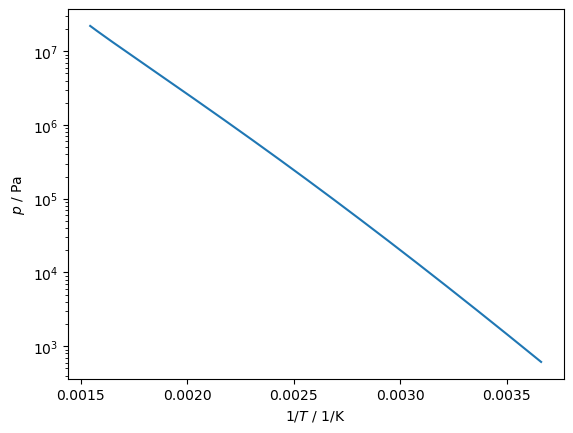

In [18]:
# The JSON data for the expansions can be accessed from CoolProp
jSuper = json.loads(CP.get_fluid_param_string("WATER", "JSON"))[0]["EOS"][0]["SUPERANCILLARY"]
SA = CP.SuperAncillary(json.dumps(jSuper))

AS = CP.AbstractState('HEOS','Water')
Tt = AS.Ttriple()
Tc = AS.T_critical()

Ts = np.linspace(Tt, 647.0959999999873, 5*10**5)
ps = np.zeros_like(Ts)
SA.eval_sat_many(Ts, 'P', 0, ps)
plt.plot(1/Ts, ps)
plt.yscale('log'); plt.gca().set(xlabel='$1/T$ / 1/K', ylabel='$p$ / Pa');

In [19]:
# At the lower level, calling with a buffer of points
tic = timeit.default_timer()
SA.eval_sat_many(Ts, 'P', 0, ps)
toc = timeit.default_timer()
print((toc-tic)/len(Ts)*1e6, 'μs/call')

0.07150249928236008 μs/call


In [20]:
# With superancillaries enabled; three functions are evaluated
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, False)
QT_INPUTS = CP.QT_INPUTS
tic = timeit.default_timer()
for T_ in Ts:
    AS.update(QT_INPUTS, 0, T_)
toc = timeit.default_timer()
print((toc-tic)/len(Ts)*1e6, 'μs/call')

26.613108166493475 μs/call


In [21]:
# With superancillaries enabled; three functions are evaluated, plus any Python <-> C overhead
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, True)
QT_INPUTS = CP.QT_INPUTS
tic = timeit.default_timer()
for T_ in Ts:
    AS.update(QT_INPUTS, 0, T_)
toc = timeit.default_timer()
print((toc-tic)/len(Ts)*1e6, 'μs/call')

0.33997100032866 μs/call


If pressure is specified, the speedup is even greater because one must also iterate for the pressure of interest:

In [22]:
pssmall = np.geomspace(ps[0], ps[-1]*(1-1e-10), 10**4)
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, False)
PQ_INPUTS = CP.PQ_INPUTS
tic = timeit.default_timer()
for p_ in pssmall:
    AS.update(PQ_INPUTS, p_, 0)
toc = timeit.default_timer()
print((toc-tic)/len(pssmall)*1e6, 'μs/call')

235.28158329427242 μs/call


In [23]:
# With superancillaries enabled, one evaluates T(p) from an inverse function and then uses that T
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, True)
PQ_INPUTS = CP.PQ_INPUTS
tic = timeit.default_timer()
for p_ in pssmall:
    AS.update(PQ_INPUTS, p_, 0)
toc = timeit.default_timer()
print((toc-tic)/len(pssmall)*1e6, 'μs/call')

0.4017041064798832 μs/call


In [ ]:
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, True)

## Other validation checks to confirm accuracy

/var/folders/jw/3zpn22_n6198zqwj0mspx0mr0000gn/T/ipykernel_58238/2247987533.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(Ts, np.abs(HFG_NON/HFG_SA-1))


Text(0.5, 0, '$T$ / K')

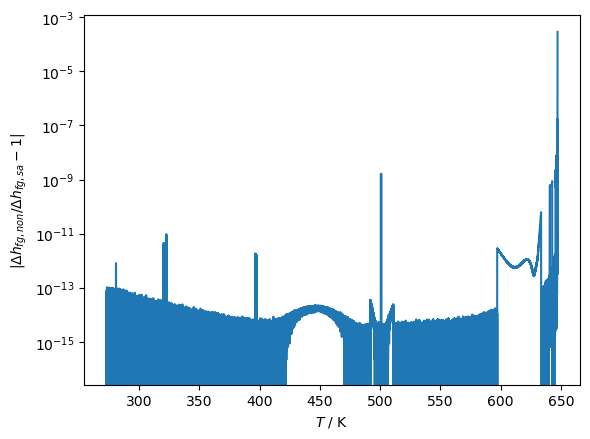

In [28]:
def get_hfg(T):
    """ Latent heat """
    AS.update(CP.QT_INPUTS, 0, T)
    return AS.saturated_vapor_keyed_output(CP.iHmolar)-AS.saturated_liquid_keyed_output(CP.iHmolar)
    
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, False)
HFG_SA = np.array([get_hfg(T_) for T_ in Ts])
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, True)
HFG_NON = np.array([get_hfg(T_) for T_ in Ts])

plt.plot(Ts, np.abs(HFG_NON/HFG_SA-1))
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, True)
plt.yscale('log')
plt.ylabel(r'$|\Delta h_{fg, non}/\Delta h_{fg, sa} - 1|$')
plt.xlabel('$T$ / K');

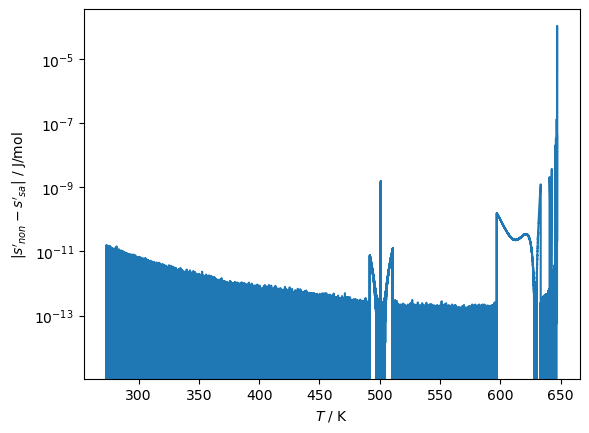

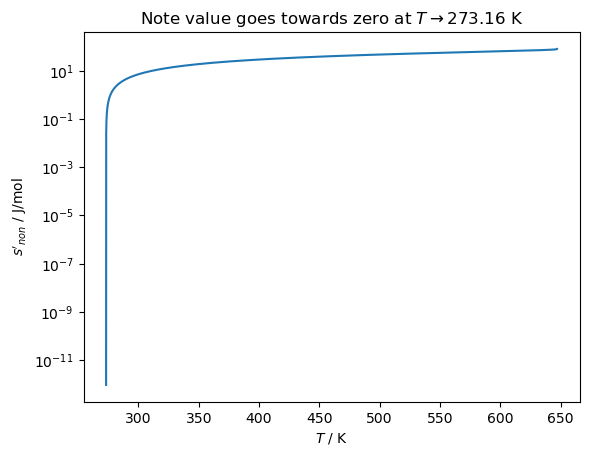

In [33]:
def get_sf(T):
    """ liquid entropy """
    AS.update(CP.QT_INPUTS, 0, T)
    return AS.saturated_liquid_keyed_output(CP.iSmolar)
    
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, False)
SF_SA = np.array([get_sf(T_) for T_ in Ts])
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, True)
SF_NON = np.array([get_sf(T_) for T_ in Ts])

plt.plot(Ts, np.abs(SF_NON - SF_SA))
plt.yscale('log')
plt.ylabel(r"$|s'_{non} - s'_{sa}|$ / J/mol")
plt.xlabel('$T$ / K');

plt.figure()
plt.plot(Ts, SF_NON)
plt.title(r'Note value goes towards zero at $T\to 273.16$ K')
plt.gca().set(ylabel=r"$s'_{non}$ / J/mol", xlabel='$T$ / K');

CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, True)

## Checks against extended precision

In [ ]:
outputversion = '2025.03.30-v2'
if not Path(f'{outputversion}.zip').exists():
    print('Downloading the chebyshev output file to ', Path('.').absolute())
    urllib.request.urlretrieve(f'https://github.com/CoolProp/fastchebpure/archive/refs/tags/{outputversion}.zip', f'{outputversion}.zip')

    with ZipFile(f'{outputversion}.zip') as z:
        print(Path(f'{outputversion}.zip').parent.absolute())
        z.extractall(Path(f'{outputversion}.zip').parent.absolute())

    with (Path('.') / f'fastchebpure-{outputversion}' / '.gitignore').open('w') as fp:
        fp.write("*")

outputcheck = (Path('.') / f'fastchebpure-{outputversion}' / 'outputcheck').absolute()
assert outputcheck.exists()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP

fluid = 'Water'

CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, False)

from pathlib import Path
CP.set_config_string(CP.ALTERNATIVE_REFPROP_PATH, str(Path('~/REFPROP10').expanduser()))

AS = CP.AbstractState('HEOS', f"{fluid}")
jSuper = json.loads(CP.get_fluid_param_string(f"{fluid}", "JSON"))[0]['EOS'][0]['SUPERANCILLARY']
superanc = CP.SuperAncillary(json.dumps(jSuper))
RPname = AS.fluid_param_string("REFPROP_name")

# Load extended precision calcs from the release on github
chk = json.load(open(f'{outputcheck}/{fluid}_check.json'))
df = pd.DataFrame(chk['data'])
# df.info() # uncomment to see what fields are available

Tcrit_num = AS.get_fluid_parameter_double(0, "SUPERANC::Tcrit_num")
T = df['T / K'].to_numpy()
Theta = (Tcrit_num-T)/Tcrit_num

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6,10))


plt.sca(axes[0])
rhoL_anc = np.zeros_like(T)
superanc.eval_sat_many(T, 'D', 0, rhoL_anc)
err = np.abs(df["rho'(mp) / mol/m^3"]/rhoL_anc-1)
plt.plot(Theta, err, 'o', label=r'$\Upsilon$:SA')

errCP = np.abs(df["rho'(mp) / mol/m^3"]/CP.PropsSI('Dmolar', 'T', T, 'Q', 0, f'HEOS::{fluid}')-1)
plt.plot(Theta, errCP, '^', label=r'$\Upsilon$:HEOS')

try:
    errRP = np.abs(df["rho'(mp) / mol/m^3"]/CP.PropsSI('Dmolar', 'T', T, 'Q', 0, f'REFPROP::{RPname}')-1)
    plt.plot(Theta, errRP, 'x', label=r'$\Upsilon$:REFPROP')
except BaseException as BE:
    print(BE)

plt.legend(loc='best')
plt.ylabel(r"$|\rho_{{\rm \Upsilon}}'/\rho_{{\rm ep}}'-1|$")
plt.yscale('log')



plt.sca(axes[1])
rhoV_anc = np.zeros_like(T)
superanc.eval_sat_many(T, 'D', 1, rhoV_anc)
err = np.abs(df["rho''(mp) / mol/m^3"]/rhoV_anc-1)
plt.plot(Theta, err, 'o', label=r'$\Upsilon$:SA')

errCP = np.abs(df["rho''(mp) / mol/m^3"]/CP.PropsSI('Dmolar', 'T', T, 'Q', 1, f'HEOS::{fluid}')-1)
plt.plot(Theta, errCP, '^', label=r'$\Upsilon$:HEOS')

try:
    errRP = np.abs(df["rho''(mp) / mol/m^3"]/CP.PropsSI('Dmolar', 'T', T, 'Q', 1, f'REFPROP::{RPname}')-1)
    plt.plot(Theta, errRP, 'x', label=r'$\Upsilon$:REFPROP')
except BaseException as BE:
    print(BE)

plt.legend(loc='best')
plt.ylabel(r"$|\rho_{{\rm \Upsilon}}''/\rho_{{\rm ep}}''-1|$")
plt.yscale('log')



plt.sca(axes[2])
p_anc = np.zeros_like(T)
superanc.eval_sat_many(T, 'P', 1, p_anc)
err = np.abs(df["p(mp) / Pa"]/p_anc-1)
plt.plot(Theta, err, 'o', label=r'$\Upsilon$:SA')

errCP = np.abs(df["p(mp) / Pa"]/CP.PropsSI('P', 'T', T, 'Q', 1, f'HEOS::{fluid}')-1)
plt.plot(Theta, errCP, '^', label=r'$\Upsilon$:HEOS')

try:
    errRP = np.abs(df["p(mp) / Pa"]/CP.PropsSI('P', 'T', T, 'Q', 1, f'REFPROP::{RPname}')-1)
    plt.plot(Theta, errRP, 'x', label=r'$\Upsilon$:REFPROP')
except BaseException as BE:
    print(BE)
plt.legend(loc='best')

# print(CP.PropsSI('gas_constant', 'T', T[0], 'Q', 1, f'HEOS::{fluid}'))
# print(CP.PropsSI('gas_constant', 'T', T[0], 'Q', 1, f'REFPROP::{fluid}'))

plt.ylabel(r"$|p_{{\rm \Upsilon}}/p_{{\rm ep}}-1|$")
plt.yscale('log')

plt.sca(axes[2])
plt.xlabel(r'$\Theta=(T_{{\rm crit,num}}-T)/T_{{\rm crit,num}}$')
plt.xscale('log')

for ax in axes:
    ax.axhline(1e-12, dashes=[2,2])
    ax.axvline(1e-6, dashes=[2,2])

plt.tight_layout(pad=0.2)
plt.show()